<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-06/Recommender-Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive

drive.mount('/content/drive')

train = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/ua.base', dtype=np.uint32)
test = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/ua.test', dtype=np.uint32)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


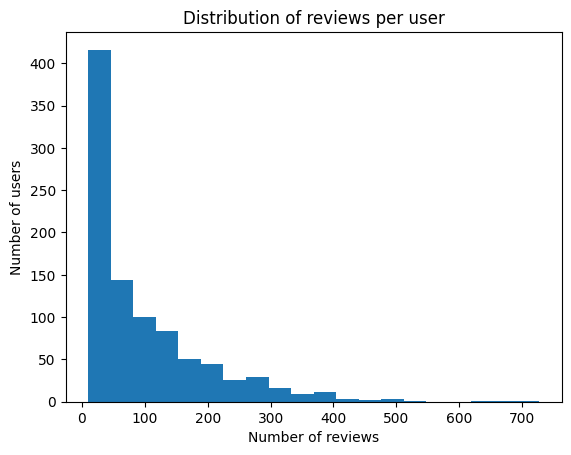

In [3]:
num_reviews = np.unique(train[:,0], return_counts=True)[1]
plt.hist(num_reviews, bins = 20)
plt.title("Distribution of reviews per user")
plt.ylabel("Number of users")
plt.xlabel("Number of reviews")
plt.show()

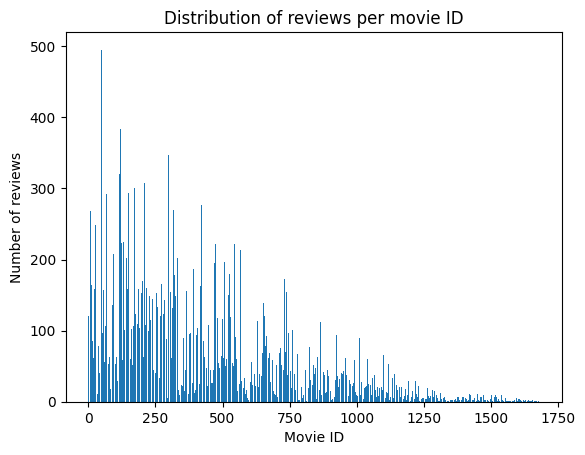

In [4]:
num_reviews = np.unique(train[:,1], return_counts=True)[1]
plt.bar(np.arange(len(num_reviews)), num_reviews)
plt.title("Distribution of reviews per movie ID")
plt.ylabel("Number of reviews")
plt.xlabel("Movie ID")
plt.show()

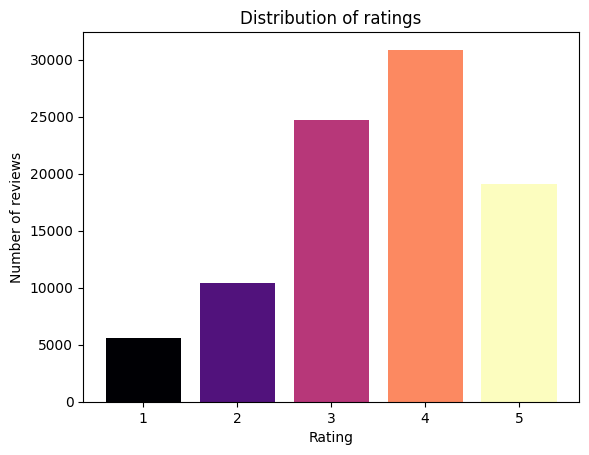

In [5]:
import matplotlib
cmap = matplotlib.colormaps['magma']

colors = [matplotlib.colors.to_hex(cmap(i)) for i in np.linspace(0, 1, 5)]

num_reviews = np.unique(train[:,2], return_counts=True)[1]
plt.bar(np.arange(1,6), num_reviews, color=colors)
plt.title("Distribution of ratings")
plt.ylabel("Number of reviews")
plt.xlabel("Rating")
plt.show()

In [6]:

uim = np.zeros((len(np.unique(train[:,0])), max(train[:,1])))

for i in range(len(np.unique(train[:,0]))):
  uim[train[i,0]-1, train[i,1]-1] = train[i,2]


In [7]:
t_dict = {k:[int(train[i,1]) for i in range(len(train)) if train[i,0] == k] for k in set(train[:,0])}
test_dict = {k:[int(test[i,1]) for i in range(len(test)) if test[i,0] == k] for k in range(1,len(np.unique(train[:,0]))+1)}

In [8]:
M = max(train[:,1])
U = len(np.unique(train[:,0]))


def ohe(t_dict, b, batch_size):
  users_ohe = np.zeros((batch_size, U))
  movies_ohe = np.zeros((batch_size, M))
  ratings_ohe = np.zeros((batch_size, 1))
  for r in range(b*batch_size, (b+1)*batch_size):
    i = r - b*batch_size
    users_ohe[i, r//M] = 1
    movies_ohe[i, r%M] = 1
    if r%M+1 in t_dict[r//M+1]:
      ratings_ohe[i,0] = 1
  return torch.Tensor(users_ohe), torch.Tensor(movies_ohe), torch.Tensor(ratings_ohe)


def HR10(pred, idx = 0):
  pred = pred.flatten()
  return int(idx in torch.argsort(pred, descending = True)[:10])

def RR(pred, idx = 0):
  pred = pred.flatten()
  return 1/((torch.argsort(pred, descending = True) == idx).nonzero()[0,0]+1)



## Matrix Factorization:

In [9]:
from scipy.sparse.linalg import svds
import torch

uim = uim-np.mean(uim, axis=1).reshape((U, 1))

u, s, vt = svds(uim, k=10)

predicted_ratings = np.dot(np.dot(u, np.diag(s)), vt)+np.mean(uim, axis=1).reshape((U, 1))

hr10 = 0
rr = 0

for u in range(U):
  ur = predicted_ratings[u]
  q = np.random.choice(test_dict[u+1], 1)
  for i in range(M):
    if i+1 in t_dict[u+1] or (i+1 != q and i+1 in test_dict[u+1]):
      ur[i] = -5
  hr10 += HR10(torch.Tensor(ur), (q-1)[0])
  rr += RR(torch.Tensor(ur), (q-1)[0])

print("HR@10: {:.5f}".format(hr10 / U))
print("MRR: {:.5f}".format(rr / U))


HR@10: 0.04030
MRR: 0.01994


## NCF

For implementing NCF, I closely followed the procedure in the paper proposing it (https://arxiv.org/pdf/1708.05031). This includes the described testing regimen, where the most recent sample is withheld from training, and 100 other movies the user did not see is then sampled for comparison. I vary this slightly, instead opting to choose one random sample from the test set for each user, and then randomly sampling 99 unwatched movies by that user.

In [10]:
from torch import nn
import torch


class NCF(nn.Module):
  def __init__(self, n_movies, n_users, embed_dim = 16, hidden_layers = 4, hidden_size = 32):
    super().__init__()
    self.user_embed_mlp = nn.Linear(n_users, embed_dim)
    self.user_embed_gmf = nn.Linear(n_users, embed_dim)
    self.movie_embed_mlp = nn.Linear(n_movies, embed_dim)
    self.movie_embed_gmf = nn.Linear(n_movies, embed_dim)

    self.MLP = nn.Sequential(
        nn.Linear(2*embed_dim, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size//2)
    )
    self.neumf = nn.Linear(hidden_size, 1)
    self.out = nn.Hardsigmoid()

  def forward(self, u, m):
    u_emb_mlp = self.user_embed_mlp(u)
    u_emb_gmf = self.user_embed_gmf(u)
    m_emb_mlp = self.movie_embed_mlp(m)
    m_emb_gmf = self.movie_embed_gmf(m)

    gmf = torch.mul(u_emb_gmf, m_emb_gmf)

    mlp = self.MLP(torch.cat((u_emb_mlp, m_emb_mlp), dim=1))

    return self.out(self.neumf(torch.cat((gmf, mlp), dim=1)))


In [11]:
from torch import optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score


model = NCF(max(train[:,1]), len(np.unique(train[:,0])))
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 5
batch_size = 1024
N = train.shape[0]

for e in range(epochs):
  model.train()
  losses = []
  for b in tqdm(range(U*M//batch_size)):
    optimizer.zero_grad()
    u_batch, m_batch, r_batch = ohe(t_dict, b, batch_size)

    pred = model(u_batch, m_batch)
    loss = loss_fn(pred, r_batch)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
  print("Epoch {} | Loss: {:.5f}".format(e, np.mean(losses)))

model.eval()
with torch.no_grad():
  test_users = U
  hr10 = 0
  rr = 0
  for u in tqdm(range(1, U+1)):
    if len(test_dict[u]) == 0:
      test_users -=1
      continue
    u_ohe = torch.zeros((100, U))
    m_ohe = torch.zeros((100, M))
    r_ohe = torch.zeros((100,1))
    u_ohe[:, u-1] = 1
    q = np.random.choice(test_dict[u], 1)
    m_ohe[0, q] = 1
    r_ohe[0, 0] = 1
    i = 1
    while i < 100:
      o = np.random.choice(range(M), 1)
      if o in t_dict[u] or o in test_dict[u]:
        continue
      m_ohe[i, o] = 1
      i+=1
    pred = model(u_ohe, m_ohe)
    hr10 += HR10(pred)
    rr += RR(pred)
  print()
  print("HR@10: {:.5f}".format(hr10 / test_users))
  print("MRR: {:.5f}".format(rr / test_users))



100%|██████████| 1548/1548 [00:57<00:00, 26.82it/s]


Epoch 0 | Loss: 0.34213


100%|██████████| 1548/1548 [00:56<00:00, 27.38it/s]


Epoch 1 | Loss: 0.28638


100%|██████████| 1548/1548 [00:57<00:00, 26.69it/s]


Epoch 2 | Loss: 0.30461


100%|██████████| 1548/1548 [00:57<00:00, 26.88it/s]


Epoch 3 | Loss: 0.28760


100%|██████████| 1548/1548 [00:55<00:00, 27.84it/s]


Epoch 4 | Loss: 0.26466


100%|██████████| 943/943 [00:35<00:00, 26.34it/s]


HR@10: 0.34358
MRR: 0.14440
